In [13]:
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
import os
import torch
from coati.common.util import batch_indexable
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from coati.models.regression.basic_due import basic_due
from coati.utils.chem import rm_radical, token_clean, rdkit_normal_smi, read_pkl, read_sdf, write_sdf
from glob import glob
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt
def read_txt(file):
    with open(file, 'r') as f:
        data = f.read().splitlines()
    return data

def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            fp_list.append(fp_as_array(mol,n_bits))
        except Exception as e:
            pass
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,),int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [2]:

def embed_and_score_in_batches_regression(
    records,
    encoder,
    tokenizer,
    batch_size=128,
    score=True,
    smiles_field="smiles",
):

    print("Embedding and scoring iterable from smiles.")
    batch_iter = batch_indexable(records, batch_size)
    num_batches = len(records) // batch_size
    with torch.no_grad():
        for i, batch in enumerate(batch_iter):
            print(f"batch: {i}/{num_batches}")
            try:
                batch_mols = [Chem.MolFromSmiles(row[smiles_field]) for row in batch]
                batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                batch_tokens = torch.tensor(
                    [
                        tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
                        if s != "*"
                        else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
                        for s in batch_smiles
                    ],
                    device=encoder.device,
                    dtype=torch.int,
                )
                batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)
                if score:
                    batch_logp = [Chem.Crippen.MolLogP(m) for m in batch_mols]
                    batch_qed = [Chem.QED.qed(m) for m in batch_mols]
                if len(batch) < 2:
                    batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                    if score:
                        batch[0]["qed"] = batch_qed[0]
                        batch[0]["logp"] = batch_logp[0]
                        batch[0]["smiles"] = batch_smiles[0]
                else:
                    for k, r in enumerate(batch):
                        batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                        if score:
                            batch[k]["qed"] = batch_qed[k]
                            batch[k]["logp"] = batch_logp[k]
                            batch[k]["smiles"] = batch_smiles[k]
            except Exception as Ex:
                print(Ex)
                continue

In [3]:

DEVICE = torch.device('cuda')
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    doc_url='./model_ckpts/ecloud_augmented_37.pkl',
)


Loading model from ./model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from ./model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [4]:
data = read_txt('./examples/conditions/target_ic50/mk14.txt')
ori_smi_pic50 = [{'smiles': i.split(',')[0], 'pic50':float(i.split(',')[1])} for i in data]
act_smi_pic50 = [i for i in ori_smi_pic50 if i['pic50'] > 4]

pdbbind = torch.load('./model_ckpts/conditions/pdbbind_4bel_cached.pt')

In [5]:
embed_and_score_in_batches_regression(act_smi_pic50, encoder, tokenizer)

Embedding and scoring iterable from smiles.
batch: 0/4
batch: 1/4
batch: 2/4
batch: 3/4
batch: 4/4


In [60]:
base = './results/conditions_tmp/'

traj = read_pkl('./results/conditions_tmp/pic50_0.pkl')[1:]

traj_files = ['./results/conditions_tmp/pic50_0.pkl','./results/conditions_tmp/pic50_3.pkl']
# traj_files = ['./results/conditions_tmp/pic50_2.pkl','./results/conditions_tmp/pic50_4.pkl']

traj = []
for i in traj_files:
    traj += read_pkl(i)[1:]

In [61]:
# use ecloud chemical space
data1 = np.array([i['emb_smiles'] for i in pdbbind])
data2 = np.array([i['emb_smiles'] for i in act_smi_pic50])
data3 = np.array([i['emb'] for i in traj])
combined_data = np.vstack([data1, data2, data3])

In [62]:
# use rdkit fingerprint
smi1 = [i['smiles'] for i in pdbbind]
smi2 = [i['smiles'] for i in act_smi_pic50]
data1 = np.array(fp_list_from_smiles_list(smi1))
data2 = np.array(fp_list_from_smiles_list(smi2))


100%|██████████| 576/576 [00:00<00:00, 5240.64it/s]


In [63]:

sorted_traj = sorted(traj, key=lambda x: x['pic50'], reverse=True)

top_10_percent_index = int(len(sorted_traj) * 0.1)

top_10_percent_smiles = [item['smiles'] for item in sorted_traj[:top_10_percent_index]]

data3 = np.array(fp_list_from_smiles_list(top_10_percent_smiles))

100%|██████████| 800/800 [00:00<00:00, 6890.61it/s]


In [64]:
from openTSNE import TSNE
from sklearn.datasets import load_digits

# 假设 data3 是用于训练的数据集
# data1 和 data2 是需要映射的数据集
tsne = TSNE(n_components=2, perplexity=30, metric='cosine', random_state=42)

# 首先训练 t-SNE 模型
embedded_data2 = tsne.fit(data2)

# 使用相同的模型映射新数据
embedded_data3 = embedded_data2.transform(data3)


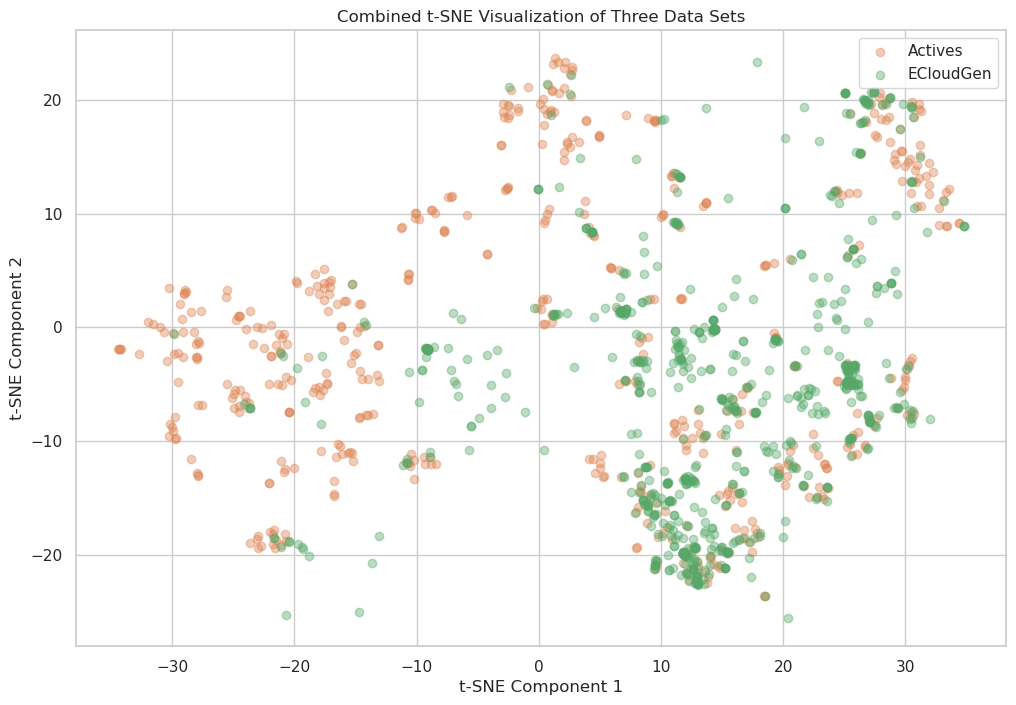

In [65]:
sns.set(style="whitegrid")  # Setting Seaborn style for better grid visibility

# Using Seaborn's "deep" color palette for distinct color per dataset
palette = sns.color_palette("deep", 3)

# Initialize the plot with specified figure size
plt.figure(figsize=(12, 8))

# Plotting each dataset with specified colors and transparency
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], color=palette[1], label='Actives', alpha=0.4)
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], color=palette[2], label='ECloudGen', alpha=0.4)
# Adding title and labels
plt.title('Combined t-SNE Visualization of Three Data Sets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Displaying the legend to identify datasets
plt.legend()

# Display the plot
plt.show()

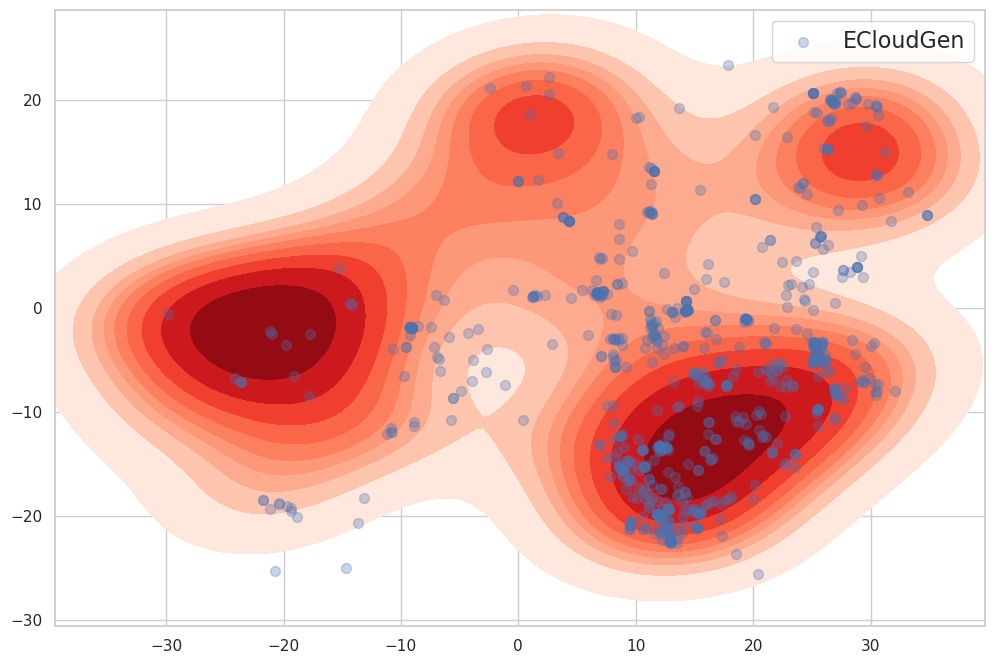

In [69]:
palette = sns.color_palette("deep", 6)
# Assuming embedded_data2 and embedded_data3 are your transformed datasets
# Calculate the overall min and max for the plotting ranges
all_data = np.vstack([embedded_data2, embedded_data3])  # Only consider data2 and data3
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

# Extending the range slightly for visual comfort
x_range = [x_min - 5, x_max + 5]
y_range = [y_min - 5, y_max + 5]

# Setup the plot
plt.figure(figsize=(12, 8))

# Data 2 KDE Plot
sns.kdeplot(x=embedded_data2[:, 0], y=embedded_data2[:, 1], cmap="Reds", fill=True, alpha=1.0)
# plt.title('KDE of Data 2 with Data 3 Scatter Overlay')
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
plt.xlim(x_range)
plt.ylim(y_range)

# Overlay Data 3 as Scatter Plot
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], color=palette[0], label='ECloudGen', alpha=0.3, s=50)
plt.legend(fontsize=16) 

plt.show()
